#Import Library dan Data

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

seed = 382938
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!pip install unrar
!unrar x bycott_rev.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from bycott_rev.rar

Creating    bycott_rev                                                OK
Extracting  bycott_rev/00000000114257.png                                  0%  OK 
Extracting  bycott_rev/00000000321655.png                                  0%  OK 
Extracting  bycott_rev/00000001112001.png                                  0%  OK 
Extracting  bycott_rev/00000001201303.png                                  0%  OK 
Extracting  bycott_rev/00000001212901.png                                  0%  OK 
Extracting  bycott_rev/00000001223004.png                                  0%  OK 
Extracting  bycott_rev/00000001231003.png                                  0%  OK 
Extracting  bycott_rev/00000001231100.png                                  0%  OK 
Extracting  bycott_rev/00000001234000.png                                  0%  OK

In [ ]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

#Exploratory Data Analysis

Number of images found:  3942
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)


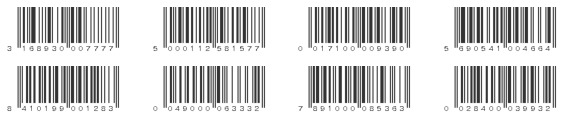

In [ ]:
# Path to the data directory
data_dir = Path("/content/bycott_rev")


# Get list of all the images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:8]

_,ax = plt.subplots(2,4, figsize=(10,2))
for i in range(8):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
plt.show()

In [ ]:
dataset = []
labels = []
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
for img in images:
  names = img.split(os.path.sep)[-1].split(".png")[0]
  labels.append(names[1:])
  dataset.append((str(img), names[1:]))
dataset = pd.DataFrame(dataset, columns=["data_dir", "labels"], index=None)
dataset = dataset.sample(frac=1.0).reset_index(drop=True)
characters = set(char for label in labels for char in label)
max_length = max([len(label) for label in labels])

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", sorted(characters))
print('Maximum length of barcode: ', max_length)
dataset

Number of images found:  3942
Number of labels found:  3942
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Maximum length of barcode:  13


,data_dir,labels
0,/content/bycott_rev/05449000092038.png,5449000092038
1,/content/bycott_rev/00000086927383.png,0000086927383
2,/content/bycott_rev/05000112592023.png,5000112592023
3,/content/bycott_rev/07622210996916.png,7622210996916
4,/content/bycott_rev/09343888000122.png,9343888000122
...,...,...
3937,/content/bycott_rev/04800888170910.png,4800888170910
3938,/content/bycott_rev/07613034636102.png,7613034636102
3939,/content/bycott_rev/05690541008150.png,5690541008150
3940,/content/bycott_rev/05000112544633.png,5000112544633


Convert image to pixel

#Split Train-Testing

In [ ]:
# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=87, img_width=231):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["data_dir"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img - cv2.resize(img,(img_width,img_height))
        img = img.astype(np.float32)
        images[i, :, :] = img
        label = list(map(int, df["labels"][i]))
        
        # Add only if it is a valid captcha
        labels[i] = label
    images = tf.transpose(images, perm=[0, 2, 1])
    
    return images.numpy(), np.array(labels)

In [ ]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  3153
Number of validation samples:  789


In [ ]:
# Build training data
training_images, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_images.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation data
validation_images, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_images.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training images:  (3153, 231, 87)
Number of training labels:  (3153, 13)
Number of validation images:  (789, 231, 87)
Number of validation labels:  (789, 13)


In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  ### START CODE HERE

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  training_images = np.expand_dims(training_images,axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values 
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(rescale = 1./255.)


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=5) 

  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=5) 

  ### END CODE HERE

  return train_generator, validation_generator

In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (3153, 231, 87, 1)
Labels of training generator have shape: (3153, 13)
Images of validation generator have shape: (789, 231, 87, 1)
Labels of validation generator have shape: (789, 13)


Training

CNN Biasa

In [ ]:
#Model lebih simple
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(231,87,1), name="images", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = layers.Conv2D(65,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps

    x = layers.Reshape(target_shape=(13,5985), name='reshape')(x)

    # FC layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer
    output = layers.Dense(10, activation="softmax", name="dense")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 231, 87, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 231, 87, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 115, 43, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 115, 43, 65)       18785     
                                                                 
 pool2 (MaxPooling2D)        (None, 57, 21, 65)        0         
                                                                 
 reshape (Reshape)           (None, 13, 5985)          0         
                                                                 
 dense1 (Dense)              (None, 13, 

In [ ]:
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator)

Epoch 1/5
127/127 [==============================] - 4s 25ms/step - loss: 1.8450 - accuracy: 0.4261 - val_loss: 1.0087 - val_accuracy: 0.6641
Epoch 2/5
127/127 [==============================] - 3s 22ms/step - loss: 0.6607 - accuracy: 0.7712 - val_loss: 0.4780 - val_accuracy: 0.8229
Epoch 3/5
127/127 [==============================] - 3s 21ms/step - loss: 0.4198 - accuracy: 0.8331 - val_loss: 0.3770 - val_accuracy: 0.8462
Epoch 4/5
127/127 [==============================] - 3s 22ms/step - loss: 0.3585 - accuracy: 0.8524 - val_loss: 0.3393 - val_accuracy: 0.8610
Epoch 5/5
127/127 [==============================] - 3s 22ms/step - loss: 0.3277 - accuracy: 0.8671 - val_loss: 0.3185 - val_accuracy: 0.8686


#Prediction and Evaluation

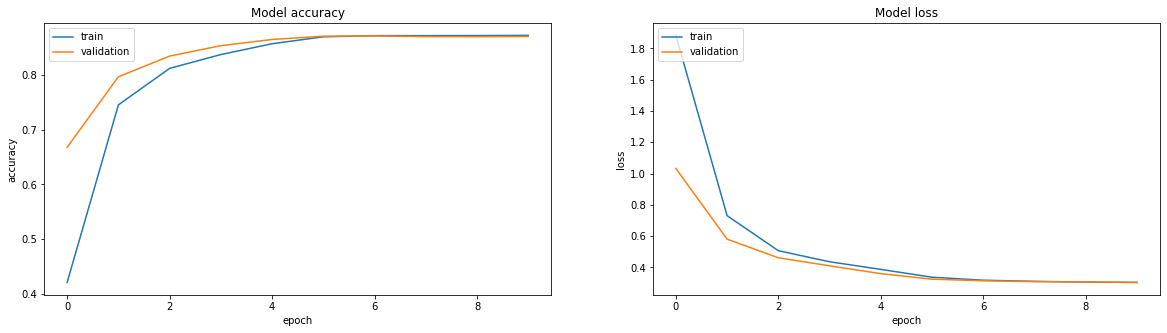

In [ ]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
validation_pred = model.predict(validation_images)
validation_pred = np.argmax(validation_pred, axis=2)
compute_perf_metric(validation_pred, validation_labels)

0.8686750511845569

In [ ]:
print(validation_pred[:30])
#print('Ini yg asli')
#print(validation_labels[:5])

[[9 3 0 0 6 6 3 4 6 1 3 0 5]
 [4 7 9 2 2 4 1 0 0 0 0 6 5]
 [8 7 1 2 5 6 1 6 2 3 3 0 5]
 [7 8 9 2 8 4 0 2 0 1 7 7 5]
 [6 0 0 1 0 6 5 6 0 0 0 7 5]
 [5 4 4 9 0 0 0 1 3 1 8 0 5]
 [6 6 7 4 9 9 9 3 6 2 2 7 5]
 [8 7 1 7 1 6 3 9 6 3 0 0 5]
 [5 4 4 9 0 0 0 1 8 1 3 7 5]
 [7 6 1 3 0 3 3 0 7 1 9 0 5]
 [0 0 2 8 0 0 0 5 4 5 4 6 5]
 [0 0 0 0 0 1 4 2 2 0 0 0 5]
 [6 0 0 1 0 6 8 7 0 1 4 0 5]
 [0 0 5 0 5 5 0 0 0 0 0 0 5]
 [0 0 0 0 0 7 8 9 0 0 5 0 5]
 [0 0 2 8 4 0 0 0 5 1 9 7 5]
 [7 6 1 3 0 3 4 4 8 3 1 7 5]
 [0 0 1 2 0 0 0 0 3 9 8 0 5]
 [4 8 0 1 9 8 1 1 1 2 0 0 5]
 [0 0 1 2 0 0 0 0 0 1 0 0 5]
 [0 0 5 0 0 0 0 2 5 7 5 7 5]
 [7 8 0 2 8 2 0 9 9 0 1 0 5]
 [7 6 1 3 0 3 8 3 0 9 4 6 5]
 [0 0 0 0 0 5 9 0 8 2 6 0 5]
 [0 0 0 0 0 6 2 3 2 1 6 0 5]
 [5 0 1 1 5 4 6 4 7 5 1 7 5]
 [5 0 1 1 5 4 6 4 3 5 1 7 5]
 [5 0 1 0 2 3 8 0 1 4 5 7 5]
 [5 4 4 9 0 0 0 1 5 1 7 0 5]
 [0 0 5 5 0 0 0 3 8 5 1 7 5]]
